In [1]:
!pip install nilearn;
!pip install dipy;
!pip install plotly;
!pip install sklearn;
!pip install git+https://github.com/qubvel/segmentation_models;

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-ojx5zxqf
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-ojx5zxqf
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33793 sha256=e87254a332cca8f070e8b78c71fca1ad2606611963ab7fece93f7f66d1037380
  Stored in directory: /tmp/pip-ephem-wheel-cache-z4y2ssso/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from __future__ import print_function
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
import os
import numpy as np
import nibabel
import cv2
from heapq import nlargest
import json

Using TensorFlow backend.


In [3]:
data_path = "/floyd/home/"
image_rows = 256
image_cols = 256

# train / validation
def create_data(train):  
    train_data_path = os.path.join(data_path, f'{train}')
    print(train_data_path)
    images = os.listdir(train_data_path)

    training_masks = []
    training_images = []
    for i in images:
        if i.endswith('.csv'):
            pass
        
        else:
            p = os.path.join(train_data_path, i)
            im_list = os.listdir(p)
            
            for j in im_list:
                if j.endswith('seg.nii.gz'):
                    training_masks.append(j)
                    
                else:
                    training_images.append(j)

    N = 4
    training_images = [sorted(training_images[n:n+N]) for n in range(0, len(training_images), N)]
    
    # takes only the 1st element
    training_images = [item[0] for item in training_images]
    print("No of training_images: ", len(training_images))
    #training images
    imgs_train = [] 
    #training masks
    masks_train = [] 
    
    for tumor, orig in zip(training_masks, training_images):
        tumor_folder = '_'.join(tumor.split("_")[0:3])

        #load 3D training mask
        training_mask = nibabel.load(train_data_path+'/'+tumor_folder +'/'+ tumor)
        #load 3D training image
        training_image = nibabel.load(train_data_path+'/'+tumor_folder +'/'+ orig) 
        
        for k in range(training_mask.shape[2]):
        #axial cuts are made along the z axis with undersampling
            mask_2d = np.array(training_mask.get_data()[::2, ::2, k])
            image_2d = np.array(training_image.get_data()[::2, ::2, k])
            #print(image_2d.shape)
        #we recover the 2D sections containing the tumor
        #if mask_2d contains only 0, it means that there is no tumor
            if len(np.unique(mask_2d)) != 1:
                masks_train.append(mask_2d)
                imgs_train.append(image_2d)

    print("imgs_train len: ", len(imgs_train))
    print("masks_train len: ", len(masks_train))
    imgs = np.ndarray((len(imgs_train), image_rows, image_cols), dtype=np.uint8)
    imgs_mask = np.ndarray((len(masks_train), image_rows, image_cols), dtype=np.uint8)


    for index, img in enumerate(imgs_train):
    #print(img.shape)
        img = cv2.resize(img, (image_rows, image_rows)) 
        imgs[index, :, :] = img

    for index, img in enumerate(masks_train):
        img = cv2.resize(img, (image_rows, image_rows)) 
        imgs_mask[index, :, :] = img

    np.save(f'/floyd/home/imgs_{train}.npy', imgs)
    np.save(f'/floyd/home/masks_{train}.npy', imgs_mask)
    print('Saving to .npy files done.') 

In [ ]:
create_data('train')
#create_data('validation')

In [4]:
# load the data
imgs_train_path = '/floyd/home/imgs_train.npy'
masks_train_path = '/floyd/home/masks_train.npy'

# imgs_val_path = '/floyd/home/imgs_validation.npy'
# masks_val_path = '/floyd/home/masks_validation.npy'

def load_data(imgs_train_path, masks_train_path):
    imgs_train = np.load(imgs_train_path)
    masks_train = np.load(masks_train_path)
    return imgs_train, masks_train

imgs_train, imgs_mask_train = load_data(imgs_train_path, masks_train_path)
# check the shape
print(imgs_train.shape)
print(imgs_mask_train.shape)

(24229, 256, 256)
(24229, 256, 256)


(256, 256)
<class 'numpy.ndarray'>


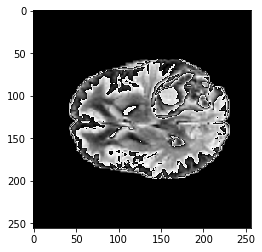

In [5]:
%matplotlib inline 
testImage = np.array(imgs_train)[100]
testImage = cv2.resize(testImage, (256, 256)) 
print(testImage.shape)
print(type(testImage))
plt.imshow(testImage, cmap = plt.cm.gray)

(256, 256)
<class 'numpy.ndarray'>


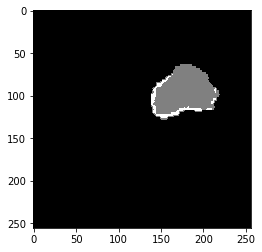

In [6]:
%matplotlib inline 
testImage = np.array(imgs_mask_train)[100]
testImage = cv2.resize(testImage, (256, 256)) 
print(testImage.shape)
print(type(testImage))
plt.imshow(testImage, cmap = plt.cm.gray)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(imgs_train, imgs_mask_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("-----------------")
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train = X_train[0:2500]
X_test = X_test[0:2500]
y_train = y_train[0:2500]
y_test = y_test[0:2500]
print("-----------------")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(19383, 256, 256)
(19383, 256, 256)
(4846, 256, 256)
(4846, 256, 256)
-----------------
(19383, 256, 256, 1)
(19383, 256, 256, 1)
(4846, 256, 256, 1)
(4846, 256, 256, 1)
-----------------
(2500, 256, 256, 1)
(2500, 256, 256, 1)
(2500, 256, 256, 1)
(2500, 256, 256, 1)


In [24]:
import segmentation_models as sm
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [25]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2500, 256, 256, 1)
(2500, 256, 256, 1)
(2500, 256, 256, 1)
(2500, 256, 256, 1)


In [26]:
# define model
model = sm.Unet(BACKBONE, input_shape= (256, 256, 1), encoder_weights=None)

In [27]:
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    'adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score])

# fit model
model.fit(
   x=X_train,
   y=y_train,
   batch_size=8,
   epochs=5,
   validation_data=(X_test, y_test))

Train on 2500 samples, validate on 2500 samples
Epoch 1/5
2500/2500 [==============================] - 180s 72ms/step - loss: 0.4671 - iou_score: 0.4399 - val_loss: 93.7894 - val_iou_score: 0.0706
Epoch 2/5
2500/2500 [==============================] - 165s 66ms/step - loss: -1.7313 - iou_score: 0.6603 - val_loss: -5.5033 - val_iou_score: 0.0999
Epoch 3/5
2500/2500 [==============================] - 165s 66ms/step - loss: -6.9378 - iou_score: 0.7776 - val_loss: -5.7929 - val_iou_score: 0.5120
Epoch 4/5
2500/2500 [==============================] - 165s 66ms/step - loss: -15.4534 - iou_score: 0.8615 - val_loss: -36.9774 - val_iou_score: 0.5384
Epoch 5/5
2500/2500 [==============================] - 165s 66ms/step - loss: -27.2446 - iou_score: 0.9076 - val_loss: -43.0163 - val_iou_score: 0.9049


In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
# from keras.models import model_from_json
# model_json = model.to_json()

# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")
# print("Saved model to disk")

In [9]:
model.load_weights('./model.h5')
print(X_test.shape)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

(2500, 256, 256, 1)



In [10]:
print(y_pred_train.shape)
print(y_pred_test.shape)

(2500, 256, 256, 1)
(2500, 256, 256, 1)


In [ ]:
for i in range(len(y_train)):
#     print(i)
#     print(i.shape)
    if i == 250:
        i = np.reshape(y_train[i], (256,256))
        plt.imshow(i, cmap = plt.cm.gray)
        break

In [ ]:
for i in range(len(y_pred_train)):
#     print(i)
#     print(i.shape)
    if i == 250:
        i = np.reshape(y_pred_train[i], (256,256))
        plt.imshow(i, cmap = plt.cm.gray)
        break

In [ ]:
for i in range(len(y_test)):
#     print(i)
#     print(i.shape)
    if i == 150:
        i = np.reshape(y_test[i], (256,256))
        plt.imshow(i, cmap = plt.cm.gray)
        break

In [ ]:
for i in range(len(y_pred_test)):
#     print(i)
#     print(i.shape)
    if i == 150:
        i = np.reshape(y_pred_test[i], (256,256))
        plt.imshow(i, cmap = plt.cm.gray)
        break 

In [ ]:
for i in range(len(X_test)):
#     print(i)
#     print(i.shape)
    if i == 150:
        i = np.reshape(X_test[i], (256,256))
        plt.imshow(i, cmap = plt.cm.gray)
        break 

In [105]:
# lets build a segmentation 
val_path = "/floyd/home/validation/BraTS20_Validation_007/BraTS20_Validation_007_flair.nii.gz"
dataIndex = val_path.split("/")[4].split("_")[2]
dataType = val_path.split("/")[3]
print(dataIndex)
print(dataType)

image_test_seg = nibabel.load(val_path)
print(image_test_seg.shape[2])
print(image_test_seg.shape)

007
validation
155
(240, 240, 155)


In [26]:
def get_coordinates(mat):

    create_list = []
    for idx, row in enumerate(mat):
        val = next((i for i, x in enumerate(row) if x), 0.0) # x!= 0 for strict match
        if val != 0:
            #print("index: ", idx)
            create_list.append(idx)

    return create_list[0], create_list[-1]

In [27]:
# typical output of the following function
"""126: (88, 114, 149, 179, 780),
 127: (90, 113, 151, 175, 552),
 128: (92, 106, 155, 172, 238),
 129: (95, 102, 160, 168, 56),
 130: (0, 0, 0, 0, 0),
 131: (0, 0, 0, 0, 0),
 132: (0, 0, 0, 0, 0),
 133: (0, 0, 0, 0, 0),"""
def create_dic(val_path):
    # path to the validation file
    image_test_seg = nibabel.load(val_path)
    
    create_list = []
    # area dictionary
    area_dic = {}
    # zero areas
    area_zero = 0
    
    for k in range(0,image_test_seg.shape[2]):
        image_seg = np.array(image_test_seg.get_data()[::2, ::2, k])
        image_seg = cv2.resize(image_seg, (256, 256)) 
        #print(image_seg.shape)
        #plt.imshow(image_seg, cmap = plt.cm.gray)
        image_seg = np.expand_dims(image_seg, axis=-1)
        #print(image_seg.shape)
        image_seg = np.expand_dims(image_seg, axis=0)
        #print(image_seg.shape)

        seg_pred_ = model.predict(image_seg)
        seg_pred_ = np.reshape(seg_pred_, (256,256))

        #convet to int
        seg_pred_ = np.int_(seg_pred_)
        #print(seg_pred_)
        seg_pred_zero = np.sum(seg_pred_)
    
        if seg_pred_zero <= 1:
            area_dic.update({k:(0,0,0,0,area_zero)})
        else:
            row1, row2 = get_coordinates(seg_pred_)
            col1, col2 = get_coordinates(seg_pred_.T)

            area = abs(row1-row2)*abs(col1-col2)
            #print(area)
            area_dic.update({k:(row1, row2, col1, col2, area)})
        
    return area_dic
area_dic = create_dic(val_path)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [28]:
## zeros are eleminated
"""126: (88, 114, 149, 179, 780),
 127: (90, 113, 151, 175, 552),
 128: (92, 106, 155, 172, 238),
 129: (95, 102, 160, 168, 56)"""
def clean_dic(area_dic):
    area_dic_output = {k: v for k, v in area_dic.items() if all(i != 0 for i in v)}
    return area_dic_output
area_dic_output = clean_dic(area_dic)

In [29]:
#typical output
"""[55, 77, 78, 79, 80, 81, 95, 96, 97..... """
def get_key_area_dic_output(area_dic_output):
    list_ = []
    for key, values in area_dic_output.items():
        list_.append(key)
    return list_
list_ = get_key_area_dic_output(area_dic_output)

In [30]:
## help us to get all the sub-dictionaries
def sub_dict(list_):
    list_ = sorted(set(list_))
    # get gaps
    g = [[s, e] for s, e in zip(list_, list_[1:]) if s+1 < e]
    # get edges
    ed = iter(list_[:1] + sum(g, []) + list_[-1:])
    return list(zip(ed, ed))

In [31]:
get_all_dic = sub_dict(list_)
print(get_all_dic)
how_Many_dict = []
for tup in get_all_dic:
    # avoid dic with single non-zero lines from area_dic
    if tup[0]!=tup[1]:
        how_Many_dict.append(tup)
print(how_Many_dict)

[(55, 55), (77, 81), (95, 129)]
[(77, 81), (95, 129)]


In [32]:
how_Many_dict

[(77, 81), (95, 129)]

In [34]:
## dictionaries with the largest range
# def dic_largest_range(how_Many_dict):
#     # choose 1 or 2 to get the largest range (if more than 2 tumors)
#     output = sorted(nlargest(2, how_Many_dict, key = lambda x: x[1] - x[0]))
#     return output





def no_of_paires(how_Many_dict):
    if len(how_Many_dict) == 1:
        output = sorted(nlargest(1, how_Many_dict, key = lambda x: x[1] - x[0]))
    elif len(how_Many_dict) == 2 :
        output = sorted(nlargest(2, how_Many_dict, key = lambda x: x[1] - x[0]))
    
    ## if we have more dic, pick the largest 2
    elif len(how_Many_dict) > 2:
        output = sorted(nlargest(2, how_Many_dict, key = lambda x: x[1] - x[0])) 
    return output

output = no_of_paires(how_Many_dict)
print(output)

[(77, 81), (95, 129)]


In [35]:
def midpoint(x1, y1, x2, y2):
    return ((x1 + x2)/2, (y1 + y2)/2)

In [41]:
# mid points
cn_1 = int((how_Many_dict[0][0] + how_Many_dict[0][1])/2)
cn_2 = int((how_Many_dict[1][0] + how_Many_dict[1][1])/2)
print(cn_1, cn_2)

79 112


In [114]:
def distinct_dic(output, area_dic_output):
    
    cube_dic1, cube_dic2, cube_dic3, cube_dic4, cube_dic5, cube_dic6 = {}, {}, {}, {}, {}, {}
    cube_dic_ = {}

    if len(output) == 2:
        a = {}
        b = {}
        for key, value in area_dic_output.items():
            if all(value):
                if key in range(output[0][0], output[0][1]+1):
                    a[key] = value
                elif key in range(output[1][0], output[1][1]+1):
                    b[key] = value
        
        k1, v1 = max(a.items(), key=lambda x:x[1][4])
        len1 = abs(v1[0] - v1[1])
        wid1 = abs(v1[2] - v1[3])
        heigh1 = abs(output[0][0] - output[0][1])
        #print(k1, v1)
        k2, v2 = max(b.items(), key=lambda x:x[1][4])
        
        #print(k2, v2)
        len2 = abs(v2[0] - v2[1])
        wid2 = abs(v2[2] - v2[3])
        heigh2 = abs(output[1][0] - output[1][1])
        # mid points of the sequence (77, 78, 79, 80, 81) ----> 79 or any other 
        
        # cn_1/cn_2 are the midpoints
        cn_1 = int((output[0][0] + output[0][1])/2)
        cn_2 = int((output[1][0] + output[1][1])/2)
        
        
        # find the midpoint
        c_a_x, c_a_y = midpoint(a.get(cn_1)[0], a.get(cn_1)[2], a.get(cn_1)[1],a.get(cn_1)[3])
        c_b_x, c_b_y = midpoint(b.get(cn_2)[0],b.get(cn_2)[2],b.get(cn_2)[1],b.get(cn_2)[3])
        
 ### create json file to feed it into the Unity!!       
        foo = ["x","y","z"] 
        bar1 = [c_a_x, c_a_y, cn_1]
        tar1 = [len1, wid1, heigh1]
                        
        bar2 = [c_b_x, c_b_y, cn_2]
        tar2 = [len2, wid2, heigh2]
        
        for f, z in zip(foo, bar1):
            cube_dic1.update({f:z})
            
        for f, z in zip(foo, tar1):
            cube_dic2.update({f:z})
        
        for f, z in zip(foo, bar2):
            cube_dic3.update({f:z})
            
        for f, z in zip(foo, tar2):
            cube_dic4.update({f:z})
           
        tumorNum = len(output)
        list_cube = [dataIndex, dataType, tumorNum, cube_dic1, cube_dic2, cube_dic3, cube_dic4]
        
        key = ["dataIndex", "dataType", "tumorNum","boxCenter", "boxDimension", "boxCenter2", "boxDimension2"]
        for w,c in zip(key, list_cube):
            cube_dic_.update({w:c})
        
        #print(cube_dic5)
        

            
#         cube_dic1.update({'boxCenter': ("x":c_a_x, "y":c_a_y, "z":cn_1)}) 
#         cube_dic2.update({'boxDimension': ("x":len1, "y":wid1, "z":heigh1)}) 
#         cube_dic3.update({'boxCenter2': ("x":c_b_x, "y":c_b_y, "z":cn_2)})  
#         cube_dic4.update({'boxDimension2': ("x": len2, "y": wid2, "z": heigh2)})
        
#         cube_dic_.update({(cube_dic1, cube_dic2, cube_dic3, cube_dic4)})
        # return x, y, z, length, width & height
        #return (c_a_x, c_a_y, cn_1, len1, wid1, heigh1, c_b_x, c_b_y, cn_2, len2, wid2, heigh2)
        
        with open('result.json', 'w') as fp:
            json.dump(cube_dic_, fp)
        
        return cube_dic_
                
    if len(output) == 1:
        c = {}
        for key, value in area_dic_output.items():
            if all(value):
                if key in range(output[0][0], output[0][1]+1):
                    c[key] = value
        k3, v3 = max(c.items(), key=lambda x:x[1][4])
        len3 = abs(v3[0] - v3[1])
        wid3 = abs(v3[2] - v3[3])
        heigh3 = abs(output[0][0] - output[0][1])
        
        cn_3 = int((how_Many_dict[0][0] + how_Many_dict[0][1])/2)
        c_c_x, c_c_y = midpoint(c.get(cn_3)[0], c.get(cn_3)[2], c.get(cn_3)[1],c.get(cn_3)[3])

 ### create json file to feed it into the Unity!!       
        bar3 = [c_c_x, c_c_y, cn_3]
        tar3 = [len3, wid3, heigh3]  
        
        for f, z in zip(foo, bar3):
            cube_dic1.update({f:z})
            
        for f, z in zip(foo, tar3):
            cube_dic2.update({f:z})
        
        tumorNum = len(output)
        list_cube = [dataIndex, dataType, tumorNum, cube_dic1, cube_dic2]
        
        key = ["dataIndex", "dataType", "tumorNum","boxCenter", "boxDimension"]
        for w,c in zip(key, list_cube):
            cube_dic_.update({w:c})        
        
        #return (c_c_x, c_c_y, cn_3, len3, wid3, heigh3)
        with open('result.json', 'w') as fp:
            json.dump(cube_dic_, fp)
        
        return cube_dic_

In [115]:
distinct_dic(output, area_dic_output)

{'dataIndex': '007',
 'dataType': 'validation',
 'tumorNum': 2,
 'boxCenter': {'x': 73.0, 'y': 155.0, 'z': 79},
 'boxDimension': {'x': 10, 'y': 10, 'z': 4},
 'boxCenter2': {'x': 70.5, 'y': 148.5, 'z': 112},
 'boxDimension2': {'x': 29, 'y': 53, 'z': 34}}